In [3]:
from itertools import chain
import logging
import numpy as np
from pathlib import Path
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf, open_dict
from typing import Dict, List, Tuple, Any, Optional
import copy
import warnings 
import time
# import matplotlib.pyplot as plt
import torch
import torch.cuda.amp as amp
from torch import Tensor, nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributed as dist
from torch.distributions.categorical import Categorical
from torch.nn.utils import clip_grad_value_
from torch.nn.parallel import DistributedDataParallel

import torchaudio
import torchaudio.transforms as T
from torchaudio.functional import mu_law_encoding, mu_law_decoding, DB_to_amplitude
import matplotlib.pyplot as plt
import PIL
import os

from torch.utils.tensorboard import SummaryWriter
import submitit
import transformers
from diffusers import DDIMScheduler
# from tensorboardX import SummaryWriter
from torchvision.utils import make_grid, save_image
from torchvision import transforms
from tqdm import trange
# from ddpm.datasets import get_dataset
# from ddpm.trainers.base_trainer import BaseTrainer
# from ddpm.datasets.audio import create_dataloader, AudioDataset
# from ddpm.diffusion import GaussianDiffusionTrainer, GaussianDiffusionSampler, HeatDiffusionTrainer, HeatDiffusionSampler
# from ddpm.model import UNet
# from ddpm.score.both import get_inception_and_fid_score
# import wandb

In [4]:
############################################ IMAGE ##################

In [5]:
### IMAGENET
%load_ext autoreload
%autoreload 2
import os
# import tllib
# from tllib.vision.datasets.segmentation.gta5 import GTA5
import torch
import numbers
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torchvision.datasets import CIFAR10, Cityscapes
from ddpm.datasets.gta5 import GTA_Pretraining_Dataset
from ddpm.datasets.cityscape import Cityscapes_Pretraining_Dataset
from ddpm.datasets.imagenet import Imagenet_Dataset
from ddpm.datasets.celeba import CelebA 

from omegaconf import DictConfig, OmegaConf, open_dict
import yaml
from ddpm.diffusion import GaussianDiffusionTrainer, GaussianDiffusionSampler, HeatDiffusionTrainer, HeatDiffusionSampler
from ddpm.model import UNet
from ddpm.ddib_model import UNetModel
from ddpm.ddib_diffusion import GaussianDiffusion, SpacedDiffusion, _extract_into_tensor, space_timesteps, LossType, ModelMeanType, ModelVarType, get_named_beta_schedule
import importlib


In [4]:
#### HELPER FUNCTIONS FOR OUR METHOD #####

def get_alpha_and_beta(t, scheduler):
    # want to run this for both current and previous timnestep
    if t.dtype==torch.long:
        alpha = scheduler.alphas_cumprod[t]
        return alpha, 1-alpha
    
    if t<0:
        return scheduler.final_alpha_cumprod, 1 - scheduler.final_alpha_cumprod

    t = t.cpu()
    low = t.floor().long()
    high = t.ceil().long()
    rem = t - low
    
    low_alpha = scheduler.alphas_cumprod[low]
    high_alpha = scheduler.alphas_cumprod[high]
    interpolated_alpha = low_alpha * rem + high_alpha * (1-rem)
    interpolated_beta = 1 - interpolated_alpha
    return interpolated_alpha, interpolated_beta

In [6]:
# imagenet_retrain_checkpoint = torch.load('/mnt/scitas/bastien/logs/IMAGENET/Imagenet_OpenAiNorm_True_[]_x256_2023-07-20_13-52/ckpt_14000.pt')
# imagenet_motion_blur_checkpoint = torch.load("/mnt/scitas/bastien/logs/IMAGENET/Imagenet_RESCALED_MSE_['motion_blur']_OAITrue_2023-07-31_21-03/ckpt_10000.pt")
# imagenet_retrain_checkpoint = torch.load('/mnt/scitas/bastien/logs/IMAGENET/Imagenet_RESCALED_MSE_[]_OAITrue_2023-08-08_14-30/ckpt_10000.pt')
ckpt_path = "/mnt/scitas/bastien/logs/IMAGENET/Imagenet_RESCALED_MSE_[]_OAITrue_2023-08-18_18-55/ckpt_225000.pt"
imagenet_retrain_checkpoint = torch.load("/mnt/scitas/bastien/logs/IMAGENET/Imagenet_RESCALED_MSE_[]_OAITrue_2023-08-18_18-55/ckpt_225000.pt")
imagenet_config = DictConfig(imagenet_retrain_checkpoint['config'])

In [7]:
from gc import collect
# del imagenet_blur_checkpoint
collect()
# imagenet_retrain_openai_checkpoint = torch.load('/mnt/scitas/bastien/logs/IMAGENET/Imagenet_256ch_True_[]_x256_2023-07-19_12-59/ckpt_16000.pt')

9

In [35]:
imagenet_cfg = {}
imagenet_cfg = imagenet_config
imagenet_cfg['trainer']['datapath'] = '/mnt/scitas/datasets/imagenet'
imagenet_cfg['trainer']["open_ai_normalization"] = True
imagenet_cfg['trainer']["split"] = "val"



imagenet_cfg = DictConfig(imagenet_cfg)

imagenet_train_transform =  transforms.Compose(
                    [   transforms.ToTensor(),
                        transforms.Resize([64]),
                        transforms.RandomCrop(imagenet_cfg.trainer.img_size),    
                    ]
                )

train_dataset_imagenet = Imagenet_Dataset(imagenet_config,transform = imagenet_train_transform)
# imagenet_cfg['trainer']["open_ai_normalization"] = True
# # imagenet_cfg['trainer']["split"] = "val"
# openai_dataset_imagenet = Imagenet_Dataset(imagenet_cfg,transform = imagenet_train_transform)

No corruption


In [31]:
### IMAGENET
%load_ext autoreload
%autoreload 2
import os
# import tllib
# from tllib.vision.datasets.segmentation.gta5 import GTA5
import torch
import numbers
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
# from torchvision.datasets import CIFAR10, Cityscapes
# from ddpm.datasets.gta5 import GTA_Pretraining_Dataset
# from ddpm.datasets.cityscape import Cityscapes_Pretraining_Dataset
from ddpm.datasets.imagenet import Imagenet_Dataset

from omegaconf import DictConfig, OmegaConf, open_dict
import yaml
from ddpm.diffusion import GaussianDiffusionTrainer, GaussianDiffusionSampler, HeatDiffusionTrainer, HeatDiffusionSampler
from ddpm.model import UNet
from ddpm.ddib_model import UNetModel
from ddpm.ddib_diffusion import GaussianDiffusion, SpacedDiffusion, _extract_into_tensor, space_timesteps, LossType, ModelMeanType, ModelVarType, get_named_beta_schedule
import importlib
# del imagenet_model
torch.cuda.empty_cache()
import gc
gc.collect()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


399

In [45]:
attention_resolutions = [32,16,8]
attention_ds = []
for res in attention_resolutions:
    attention_ds.append(64 // int(res))
class_cond = False 
diffusion_steps = 4000 
# image_size = 256 
image_size = 64 
learn_sigma = True #True 
noise_schedule = 'linear' #imagenet_cfg.trainer.beta_schedule 
num_channels = imagenet_cfg.trainer.ch #128 #256 
num_head_channels = -1 
num_heads = 4
num_res_blocks = imagenet_cfg.trainer.num_res_blocks 
resblock_updown = imagenet_cfg.trainer.resblock_updown 
use_fp16 = False
use_scale_shift_norm = False
input_channels = 3
model_var_type = ModelVarType.LEARNED_RANGE
model_mean_type = ModelMeanType.EPSILON
loss_type = LossType.RESCALED_MSE
# if imagenet_cfg.trainer.input_channel == 1:
#     out_channels = 1
# else:
out_channels = (3 if not learn_sigma else 6)

net_model = UNetModel(image_size,
                in_channels = input_channels,
                model_channels = num_channels, #128
                out_channels = out_channels,
                num_res_blocks = num_res_blocks, #2
                attention_resolutions = tuple(attention_ds),
                dropout=0.,
                channel_mult=(1, 2, 3, 4), #(1, 1, 2, 2, 4, 4),
                conv_resample=True,
                dims=2,
                num_classes=None,
                use_checkpoint=False,
                use_fp16=False,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                num_heads_upsample=-1,
                use_scale_shift_norm=use_scale_shift_norm,
                resblock_updown=resblock_updown,
                use_new_attention_order=False,
                timesteps = diffusion_steps)

print("Unets instantiated.")


net_model.load_state_dict(imagenet_retrain_checkpoint['ema_model'])
net_model.eval()
net_model = net_model.cuda(1)
# imagenet_model = imagenet_model.cuda(3)
print("Models Loaded.")

Unets instantiated.
Models Loaded.


In [42]:
imagenet_config.trainer.num_timesteps


4000

In [46]:
ddim_steps = 50

noise_schedule = 'linear'#imagenet_cfg.trainer.beta_schedule 
diffusion_steps = imagenet_config.trainer.num_timesteps
betas = get_named_beta_schedule(noise_schedule, diffusion_steps)
                                
diffusion = GaussianDiffusion(betas = betas,
                    model_mean_type = model_mean_type,
                    model_var_type = model_var_type,
                    loss_type = loss_type,
                    rescale_timesteps = False)


timesteps_respacing = f"ddim{ddim_steps}"

spaced_diffusion = SpacedDiffusion(use_timesteps=space_timesteps(diffusion_steps, timesteps_respacing),
                        betas=betas,
                        model_mean_type=model_mean_type,
                        model_var_type=model_var_type,
                        loss_type=loss_type,
                        rescale_timesteps=False,
                        )

print("Diffusions instantiated")

Diffusions instantiated


50it [00:09,  5.24it/s]


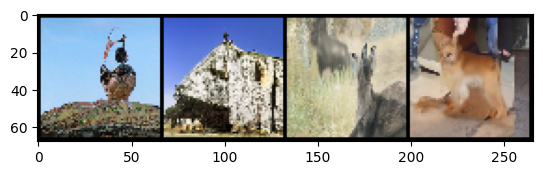

In [47]:
seed_noise = torch.randn([4,3,64,64]).cuda(1)
ddpm_imagenet_sample = spaced_diffusion.ddim_sample_loop_progressive(net_model,[4,3,64,64], 
                                                                     clip_denoised=True,noise=seed_noise)
ddpm_of_sampled_tensor = []
with torch.no_grad():
    for dic in tqdm(ddpm_imagenet_sample):
        ddpm_of_sampled_tensor.append(dic['sample'].cpu())
sample = ddpm_of_sampled_tensor[-1]
sample = ((sample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
sample = make_grid(sample.cpu()).permute(1,2,0)
plt.imshow(sample)

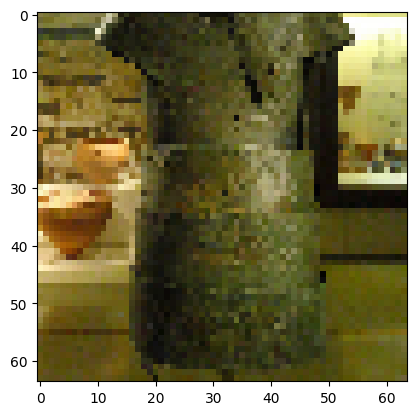

In [52]:
inputs = train_dataset_imagenet[3][0]
sample = ((inputs + 1) * 127.5).clamp(0, 255).to(torch.uint8)
# sample_openai = ((openai_0/2)+0.5)
plt.imshow(sample.permute(1,2,0).numpy())

In [54]:
### Test Encoding
# inputs = ddpm_of_sampled_tensor[-1][0].unsqueeze(0).cuda(2)
reversing_inputs = inputs.unsqueeze(0).cuda(1) #+ 0. * torch.randn_like(inputs.unsqueeze(0)).cuda(1)
encoded_images = []
decoded_images = []
# for new_inputs in inputs_list:
# inputs = new_inputs.float().cuda(1)
# inputs = z.unsqueeze(0).cuda(1)
# inputs = ddpm_of_post_resampled_tensor[-1].cuda(1)
reverse_encoding = spaced_diffusion.ddim_reverse_sample_loop_progressive(net_model,reversing_inputs,
                                                                             clip_denoised=True, eta=0.)
ddpm_of_reencoded_tensor = []
ddpm_of_reencoded_attentions = []
with torch.no_grad():
    for dic in tqdm(reverse_encoding):
        ddpm_of_reencoded_tensor.append(dic['sample'].cpu())
        # for key in dic['attention_maps']:
        #     list_cpu = [layer.cpu() for layer in dic['attention_maps'][key]]
        #     dic['attention_maps'][key] = list_cpu
        # ddpm_of_reencoded_attentions.append(dic['attention_maps'])
# print(f"L2 between seed noise and its re-encoding {((ddpm_of_reencoded_tensor[-1] - seed_noise.cpu())**2).mean()}")
encoded_images.append(ddpm_of_reencoded_tensor[-1])
ddpm_imagenet_sample = spaced_diffusion.ddim_sample_loop_progressive(net_model,[1,3,64,64], 
                                                clip_denoised=True,noise=ddpm_of_reencoded_tensor[-1].cuda(1))
ddpm_of_resampled_tensor = []
# ddpm_of_resampled_attentions = []
with torch.no_grad():
    for dic in tqdm(ddpm_imagenet_sample):
        ddpm_of_resampled_tensor.append(dic['sample'].cpu())
        # ddpm_of_resampled_attentions.append(dic['attention_maps'])
decoded_images.append(ddpm_of_resampled_tensor[-1])

50it [00:02, 21.03it/s]
50it [00:02, 21.59it/s]


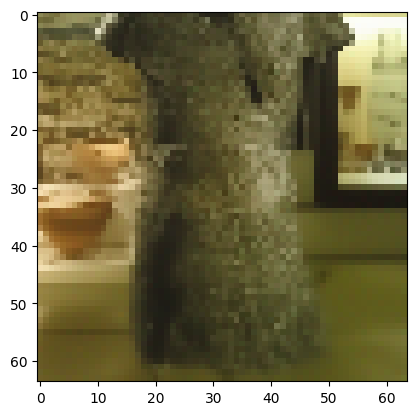

In [55]:
## Reconstruction
newsample = ddpm_of_resampled_tensor[-1]
newsample = ((newsample/2)+0.5)
newsample = make_grid(newsample.cpu().detach()).permute(1,2,0)
plt.imshow(newsample)

In [56]:
import scipy

In [42]:
out, att = motion_blur_model(img_blur.unsqueeze(0).cuda(2), torch.tensor([50]).cuda(2), return_attention=True)

In [47]:
# Generating attention mask
attn_res = 32
attn_mask = att['input'][0].reshape(1, 4, attn_res ** 2, attn_res ** 2).mean(1, keepdim=False).sum(1, keepdim=False)
# attn_mask = att['input'][0].reshape(1, 8, attn_res ** 2, attn_res ** 2).mean(1, keepdim=False).sum(1, keepdim=False) > 1.0
attn_mask = attn_mask.reshape(1, attn_res, attn_res).unsqueeze(1)#.repeat(1, 3, 1, 1).float()
attn_mask = torch.nn.functional.interpolate(attn_mask, (256, 256))

In [48]:
attn_res = 32
heads = 4
attn_mask = att['input'][0].reshape(1, heads, attn_res ** 2, attn_res ** 2).mean(2, keepdim=False)
attn_mask = attn_mask.reshape(heads, attn_res, attn_res).unsqueeze(1)
attn_mask = torch.nn.functional.interpolate(attn_mask, (256, 256))


In [50]:
# alpha = 0.5
# new_mask = alpha * attn_mask.cpu() + (1-alpha) * ori_attn_mask.cpu()

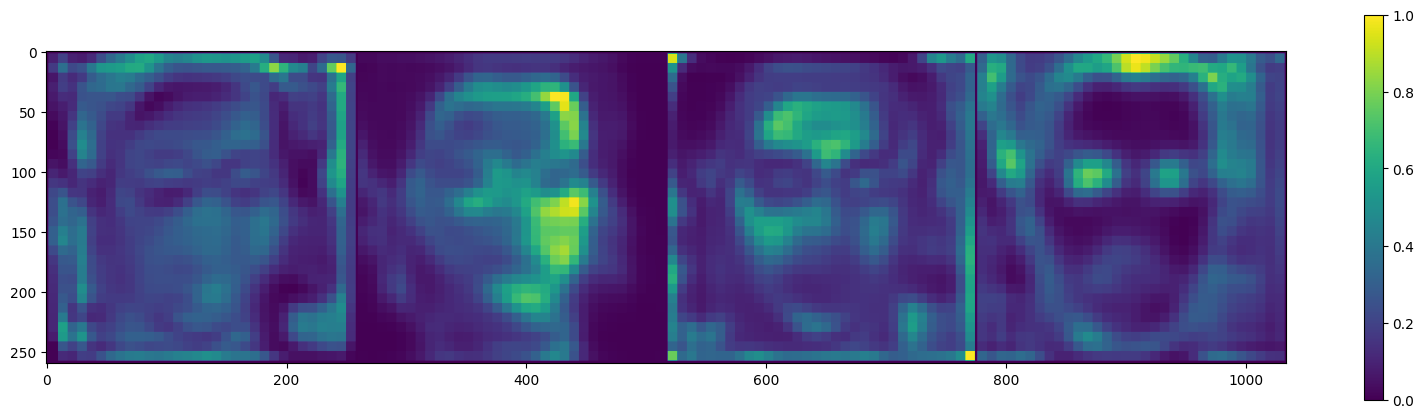

In [51]:
attn_res = 32
heads = 4
attn_mask = att['input'][0].reshape(1, heads, attn_res ** 2, attn_res ** 2).mean(2, keepdim=False)
attn_mask = attn_mask.reshape(heads, attn_res, attn_res).unsqueeze(1)
attn_mask = torch.nn.functional.interpolate(attn_mask, (256, 256))
plt.figure(figsize = (20,5))
plt.imshow(make_grid(attn_mask.cpu().data, normalize=True, scale_each = True, nrow=4)[0].unsqueeze(0).permute(1,2,0))
plt.colorbar()

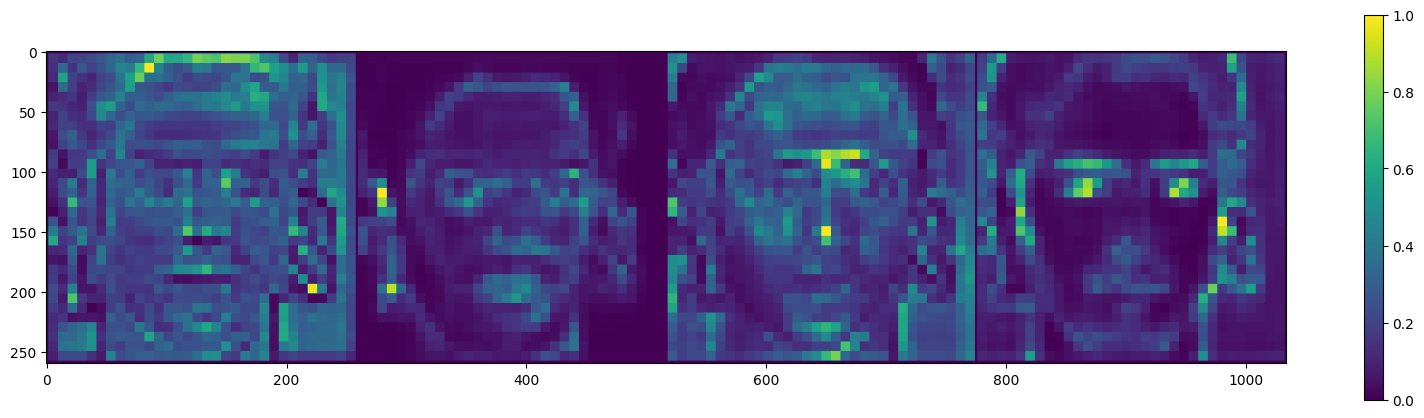

In [54]:
# attn_res = 32
# heads = 4
attn_mask = ori_att['input'][0].reshape(1, heads, attn_res ** 2, attn_res ** 2).mean(2, keepdim=False)
attn_mask = attn_mask.reshape(heads, attn_res, attn_res).unsqueeze(1)
attn_mask = torch.nn.functional.interpolate(attn_mask, (256, 256))
plt.figure(figsize = (20,5))
plt.imshow(make_grid(attn_mask.cpu().data, normalize=True, scale_each = True, nrow=4)[0].unsqueeze(0).permute(1,2,0))
plt.colorbar()

In [61]:
attn_res = 32
heads = 4
ori_attn_mask = ddpm_of_resampled_attentions[40]['output'][-1].reshape(1, heads, attn_res ** 2, attn_res ** 2).mean(2, keepdim=False)
ori_attn_mask = ori_attn_mask.reshape(heads, attn_res, attn_res).unsqueeze(1)
ori_attn_mask = torch.nn.functional.interpolate(ori_attn_mask, (256, 256))

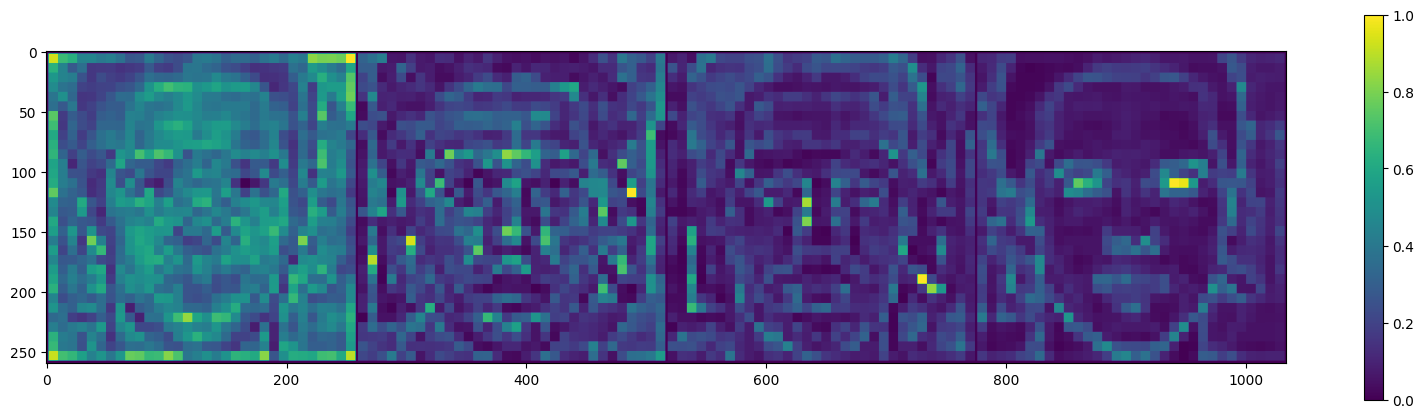

In [62]:
plt.figure(figsize = (20,5))
plt.imshow(make_grid(ori_attn_mask.cpu().data, normalize=True, scale_each = True, nrow=4)[0].unsqueeze(0).permute(1,2,0))
plt.colorbar()

In [63]:
attn_res = 32
heads = 4
ori_attn_mask = ddpm_of_reencoded_attentions[10]['output'][-1].reshape(1, heads, attn_res ** 2, attn_res ** 2).mean(2, keepdim=False)
ori_attn_mask = ori_attn_mask.reshape(heads, attn_res, attn_res).unsqueeze(1)
ori_attn_mask = torch.nn.functional.interpolate(ori_attn_mask, (256, 256))

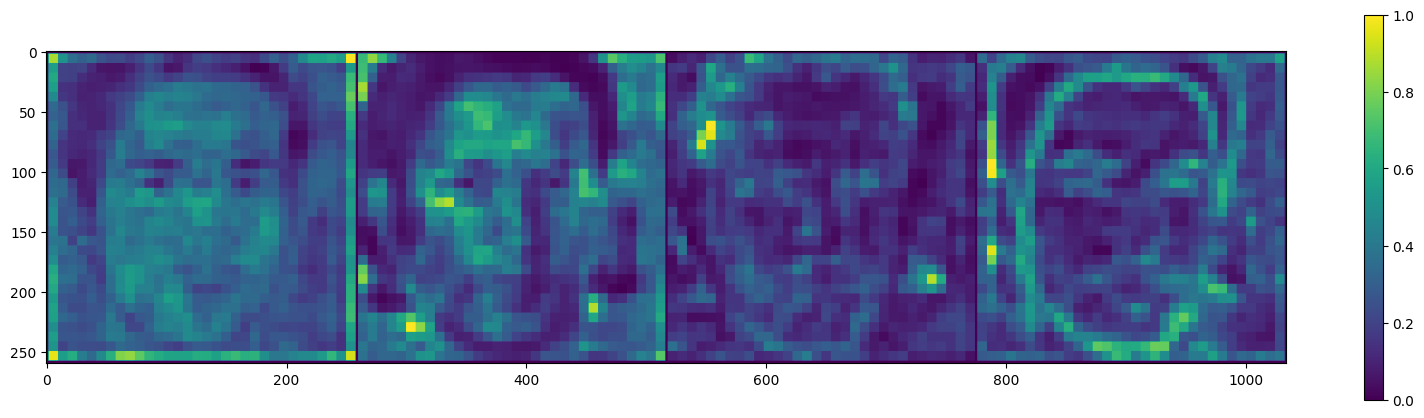

In [64]:
plt.figure(figsize = (20,5))
plt.imshow(make_grid(ori_attn_mask.cpu().data, normalize=True, scale_each = True, nrow=4)[0].unsqueeze(0).permute(1,2,0))
plt.colorbar()

In [257]:
(ori_attn_mask.cpu() - attn_mask.cpu()).abs().mean()

tensor(0.0003)

In [24]:
### TEST SAMPLING

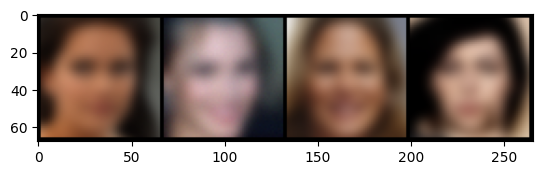

In [86]:
import gc
del ddpm_of_resampled_attentions
del ddpm_of_reencoded_attentions
torch.cuda.empty_cache()
gc.collect()

3315

In [159]:
### Test Encoding
# inputs = ddpm_of_sampled_tensor[-1][0].unsqueeze(0).cuda(2)
inputs = openai_0.unsqueeze(0).cuda(1)
reverse_encoding = spaced_diffusion.ddim_reverse_sample_loop_progressive(net_model,inputs ,
                                                                             clip_denoised=True, eta=0.)
ddpm_of_reencoded_tensor = []
ddpm_of_reencoded_attentions = []
with torch.no_grad():
    for dic in tqdm(reverse_encoding):
        ddpm_of_reencoded_tensor.append(dic['sample'].cpu())
        for key in dic['attention_maps']:
            list_cpu = [layer.cpu() for layer in dic['attention_maps'][key]]
            dic['attention_maps'][key] = list_cpu
        ddpm_of_reencoded_attentions.append(dic['attention_maps'])
# print(f"L2 between seed noise and its re-encoding {((ddpm_of_reencoded_tensor[-1] - seed_noise.cpu())**2).mean()}")

ddpm_imagenet_sample = spaced_diffusion.ddim_sample_loop_progressive(net_model,[1,3,256,256], 
                                                clip_denoised=True,noise=ddpm_of_reencoded_tensor[-1].cuda(1))
ddpm_of_resampled_tensor = []
ddpm_of_resampled_attentions = []
with torch.no_grad():
    for dic in tqdm(ddpm_imagenet_sample):
        ddpm_of_resampled_tensor.append(dic['sample'].cpu())
        ddpm_of_resampled_attentions.append(dic['attention_maps'])
        


100it [00:31,  3.19it/s]
100it [00:28,  3.55it/s]


In [120]:
 ddpm_of_resampled_attentions[-1]['input'][0].shape

torch.Size([8, 1024, 1024])

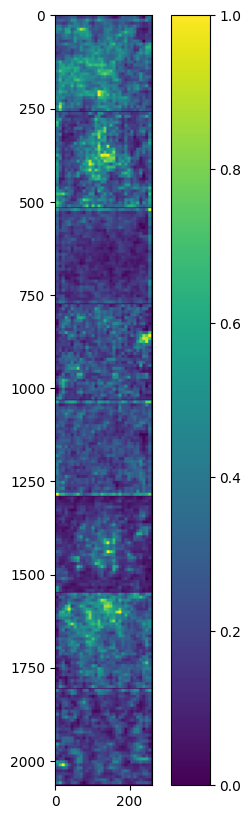

In [188]:
attn_res = 32
heads = 8
ori_attn_mask = ddpm_of_resampled_attentions[-99]['output'][-1].reshape(1, heads, attn_res ** 2, attn_res ** 2).mean(2, keepdim=False)
ori_attn_mask = ori_attn_mask.reshape(heads, attn_res, attn_res).unsqueeze(1)
ori_attn_mask = torch.nn.functional.interpolate(ori_attn_mask, (256, 256))
plt.figure(figsize = (5,10))
plt.imshow(make_grid(ori_attn_mask.cpu().data, normalize=True, scale_each = True, nrow=1)[0].unsqueeze(0).permute(1,2,0))
plt.colorbar()

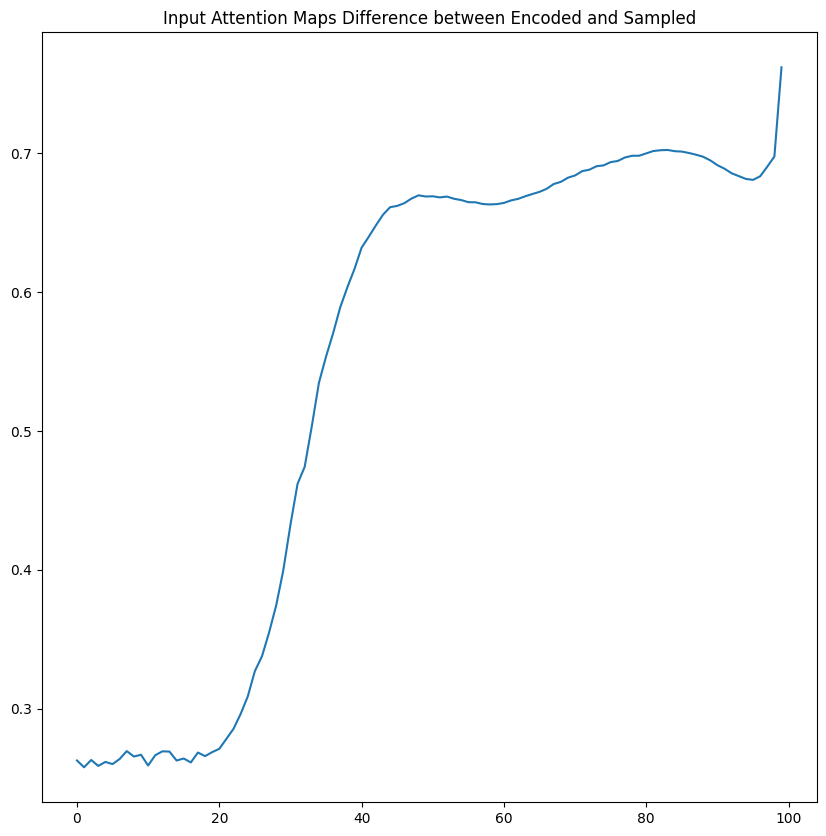

In [142]:
## Compute Distances
differences = []
for i in range(100):
    new = ddpm_of_resampled_attentions[i]['input'][0].reshape(1, heads, attn_res ** 2, attn_res ** 2).sum(2, keepdim=False)#.mean(1,keepdim=False)
    original = ddpm_of_reencoded_attentions[99-i]['input'][0].reshape(1, heads, attn_res ** 2, attn_res ** 2).sum(2, keepdim=False)#.mean(1,keepdim=False)
    differences.append(torch.abs(new.cpu()-original.cpu()).mean().cpu().item())
plt.figure(figsize = (10,10))
plt.title("Input Attention Maps Difference between Encoded and Sampled")
plt.plot(differences)

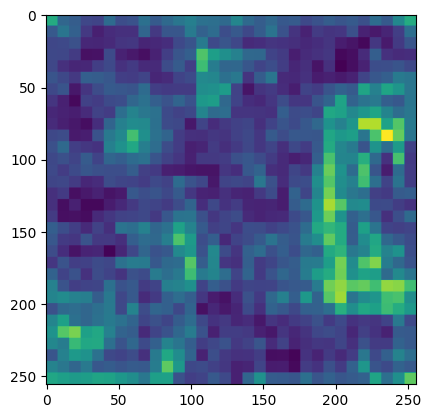

In [171]:

attn_mask = ddpm_of_reencoded_attentions[60]['input'][0].reshape(1, heads, attn_res ** 2, attn_res ** 2).mean(1, keepdim=False).sum(1, keepdim=False)
# attn_mask = att['input'][0].reshape(1, 8, attn_res ** 2, attn_res ** 2).mean(1, keepdim=False).sum(1, keepdim=False) > 1.0
attn_mask = attn_mask.reshape(1, attn_res, attn_res).unsqueeze(1)#.repeat(1, 3, 1, 1).float()
attn_mask = torch.nn.functional.interpolate(attn_mask, (256, 256))
plt.imshow(attn_mask[0].cpu().permute(1,2,0))

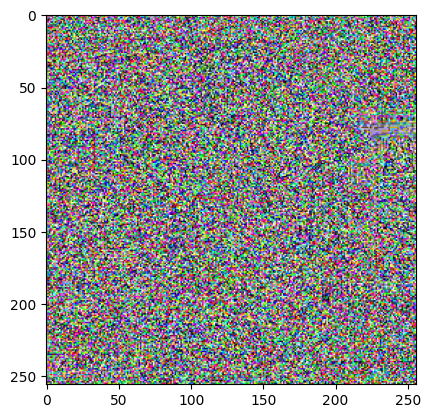

In [126]:
newsample = ddpm_of_reencoded_tensor[-1]
newsample = ((newsample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
newsample = make_grid(newsample.cpu()).permute(1,2,0)
plt.imshow(newsample)

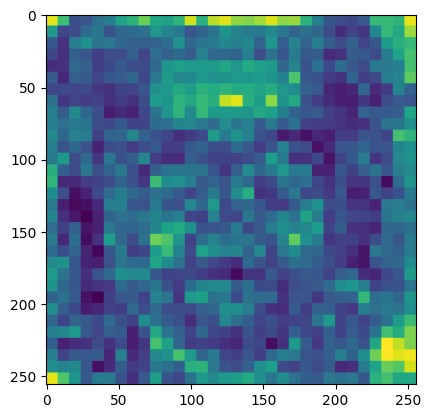

In [89]:
attn_res = 32
heads = 4
attn_mask = ddpm_of_resampled_attentions[-1]['output'][-1].reshape(1, heads, attn_res ** 2, attn_res ** 2).mean(1, keepdim=False).sum(1, keepdim=False)
# attn_mask = att['input'][0].reshape(1, 8, attn_res ** 2, attn_res ** 2).mean(1, keepdim=False).sum(1, keepdim=False) > 1.0
attn_mask = attn_mask.reshape(1, attn_res, attn_res).unsqueeze(1)#.repeat(1, 3, 1, 1).float()
attn_mask = torch.nn.functional.interpolate(attn_mask, (256, 256))
plt.imshow(attn_mask[0].cpu().permute(1,2,0))

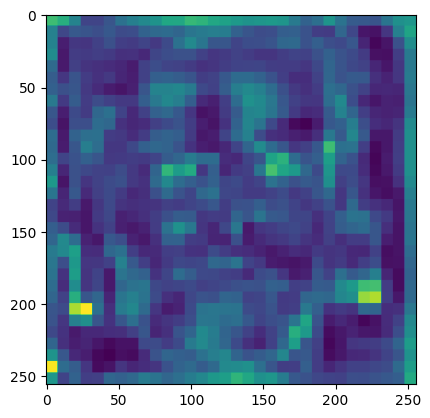

In [90]:
attn_mask = ddpm_of_reencoded_attentions[0]['output'][-1].reshape(1, heads, attn_res ** 2, attn_res ** 2).mean(1, keepdim=False).sum(1, keepdim=False)
# attn_mask = att['input'][0].reshape(1, 8, attn_res ** 2, attn_res ** 2).mean(1, keepdim=False).sum(1, keepdim=False) > 1.0
attn_mask = attn_mask.reshape(1, attn_res, attn_res).unsqueeze(1)#.repeat(1, 3, 1, 1).float()
attn_mask = torch.nn.functional.interpolate(attn_mask, (256, 256))
plt.imshow(attn_mask[0].cpu().permute(1,2,0))

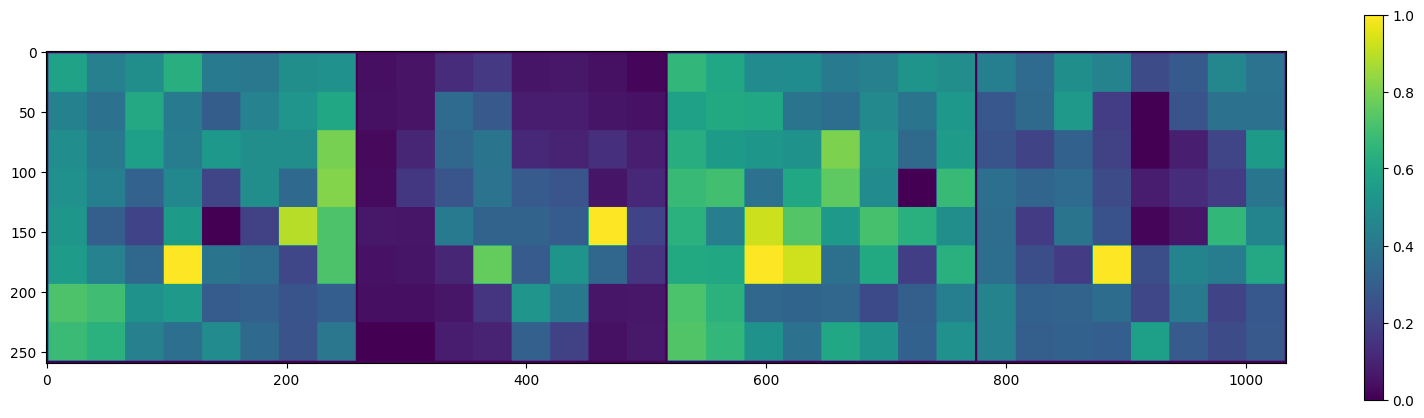

In [59]:
ori_attn_mask = ddpm_of_resampled_attentions[-25]['middle'][-1].reshape(1, heads, attn_res ** 2, attn_res ** 2).mean(2, keepdim=False)
ori_attn_mask = ori_attn_mask.reshape(heads, attn_res, attn_res).unsqueeze(1)
ori_attn_mask = torch.nn.functional.interpolate(ori_attn_mask, (256, 256))
plt.figure(figsize = (20,5))
plt.imshow(make_grid(ori_attn_mask.cpu().data, normalize=True, scale_each = True, nrow=4)[0].unsqueeze(0).permute(1,2,0))
plt.colorbar()

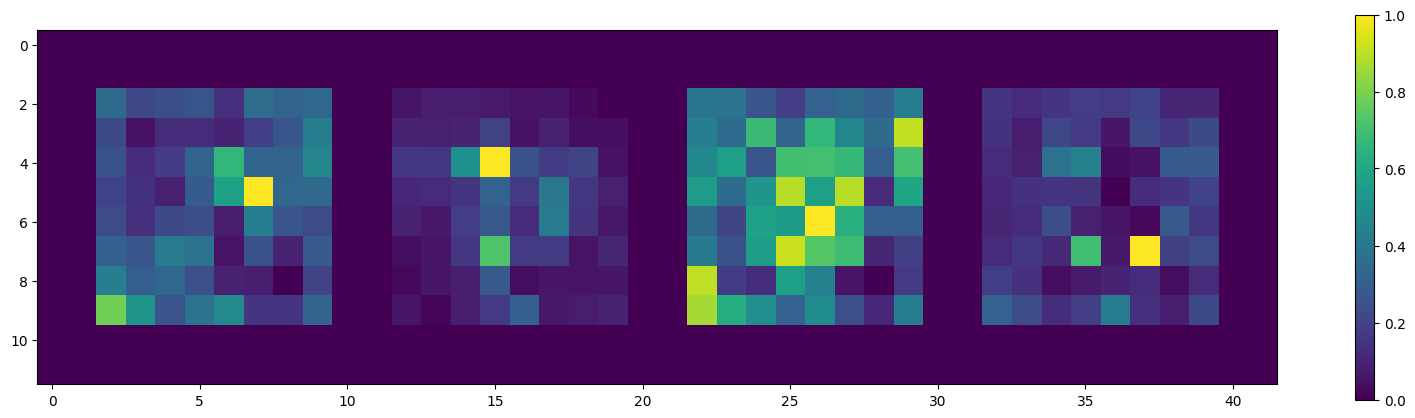

In [61]:
ori_attn_mask = ddpm_of_reencoded_attentions[25]['middle'][-1].reshape(1, heads, attn_res ** 2, attn_res ** 2).mean(2, keepdim=False)
ori_attn_mask = ori_attn_mask.reshape(heads, attn_res, attn_res).unsqueeze(1)
# ori_attn_mask = torch.nn.functional.interpolate(ori_attn_mask, (256, 256))
plt.figure(figsize = (20,5))
plt.imshow(make_grid(ori_attn_mask.cpu().data, normalize=True, scale_each = True, nrow=4)[0].unsqueeze(0).permute(1,2,0))
plt.colorbar()

In [ ]:
attn_res = 32
attn_mask = ddpm_of_resampled_attentions[40]['output'][-1].reshape(1, heads, attn_res ** 2, attn_res ** 2).mean(1, keepdim=False).sum(1, keepdim=False)
# attn_mask = att['input'][0].reshape(1, 8, attn_res ** 2, attn_res ** 2).mean(1, keepdim=False).sum(1, keepdim=False) > 1.0
attn_mask = attn_mask.reshape(1, attn_res, attn_res).unsqueeze(1)#.repeat(1, 3, 1, 1).float()
attn_mask = torch.nn.functional.interpolate(attn_mask, (256, 256))
plt.imshow(attn_mask[0].cpu().permute(1,2,0))

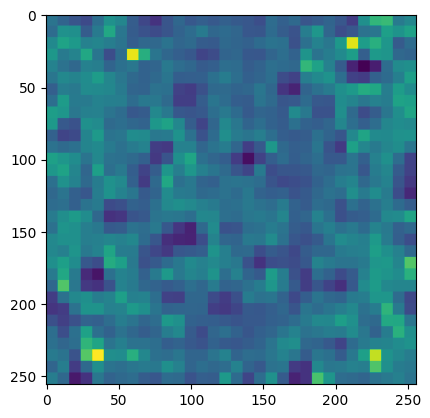

In [81]:
attn_res = 32
attn_mask = ddpm_of_reencoded_attentions[45]['output'][-1].reshape(1, heads, attn_res ** 2, attn_res ** 2).mean(1, keepdim=False).sum(1, keepdim=False)
# attn_mask = att['input'][0].reshape(1, 8, attn_res ** 2, attn_res ** 2).mean(1, keepdim=False).sum(1, keepdim=False) > 1.0
attn_mask = attn_mask.reshape(1, attn_res, attn_res).unsqueeze(1)#.repeat(1, 3, 1, 1).float()
attn_mask = torch.nn.functional.interpolate(attn_mask, (256, 256))
plt.imshow(attn_mask[0].cpu().permute(1,2,0))

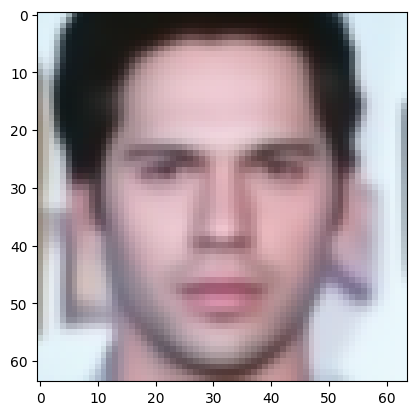

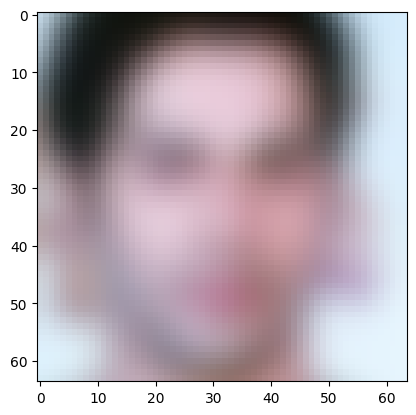

In [201]:
openai = openai_dataset_imagenet[5][0]
sample_openai = ((openai + 1) * 127.5).clamp(0, 255).to(torch.uint8)
plt.imshow(sample_openai.permute(1,2,0).numpy())

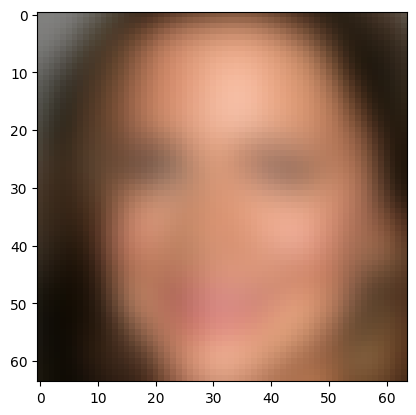

In [56]:
openai_0 = openai_dataset_imagenet[3][0]
sample_openai = ((openai_0 + 1) * 127.5).clamp(0, 255).to(torch.uint8)
plt.imshow(sample_openai.permute(1,2,0).numpy())

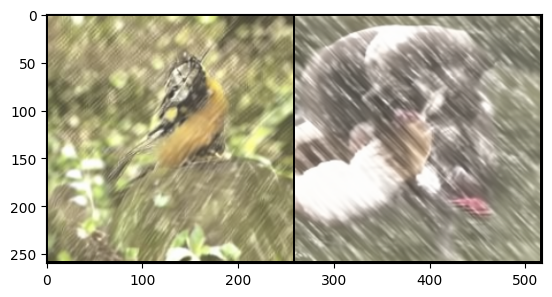

In [170]:
sample = ddpm_of_resampled_tensor[-1]
sample = ((sample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
sample = make_grid(sample.cpu()).permute(1,2,0)
plt.imshow(sample)

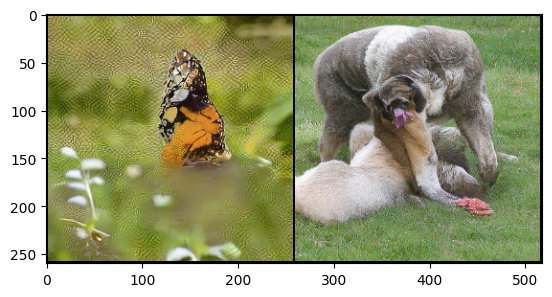

In [141]:
sample = ddpm_of_resampled_tensor[-1]
sample = ((sample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
sample = make_grid(sample.cpu()).permute(1,2,0)
plt.imshow(sample)

In [ ]:
### TEST BRIDGE

In [344]:
# seed_noise = torch.randn([4,3,256,256]).cuda(2)
ddpm_imagenet_sample = spaced_diffusion.ddim_sample_loop_progressive(imagenet_model,[2,3,256,256], 
                                                                     clip_denoised=True,noise=seed_noise.cuda(2))
ddpm_of_sampled_tensor = []
with torch.no_grad():
    for dic in tqdm(ddpm_imagenet_sample):
        ddpm_of_sampled_tensor.append(dic['sample'].cpu())

100it [00:25,  3.89it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


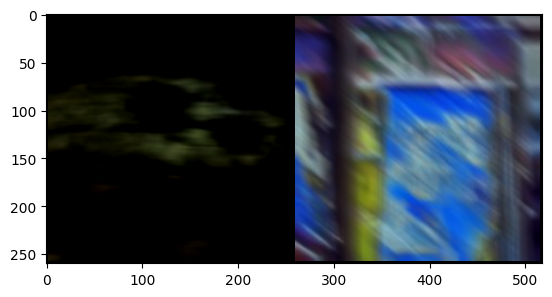

In [345]:
sample = ddpm_of_sampled_tensor[-1]
# sample = ((sample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
sample = make_grid(sample.cpu()).permute(1,2,0)
plt.imshow(sample)

In [ ]:
### Test Reverse Encoding

In [366]:
inputs = openai_0.unsqueeze(0).cuda(3)
# inputs = ((inputs + 1) * 127.5).clamp(0, 255)/255
# inputs = ddpm_of_sampled_tensor[-1].cuda(1)
reverse_encoding = spaced_diffusion.ddim_reverse_sample_loop_progressive(imagenet_model,inputs ,
                                                                             clip_denoised=False)
ddpm_of_encoded_tensor = []
with torch.no_grad():
    for dic in tqdm(reverse_encoding):
        ddpm_of_encoded_tensor.append(dic['sample'].cpu())


100it [00:14,  6.89it/s]


In [368]:
ddpm_of_encoded_tensor[-1][0].std()

tensor(0.9797)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


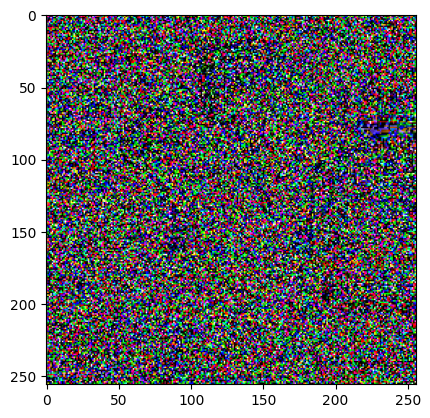

In [369]:
ddpm_of_encoded_tensor
plt.imshow(ddpm_of_encoded_tensor[-1][0].permute(1,2,0).numpy())

In [370]:
inputs = ddpm_of_encoded_tensor[-1].cuda(2)
reverse_decoding = spaced_diffusion.ddim_sample_loop_progressive(blur_model,shape=[1,3,256,256],clip_denoised=True,
                                                                 noise=inputs)
ddpm_of_decoded_tensor = []
with torch.no_grad():
    for dic in tqdm(reverse_decoding):
        ddpm_of_decoded_tensor.append(dic['sample'].cpu())



100it [00:14,  6.96it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


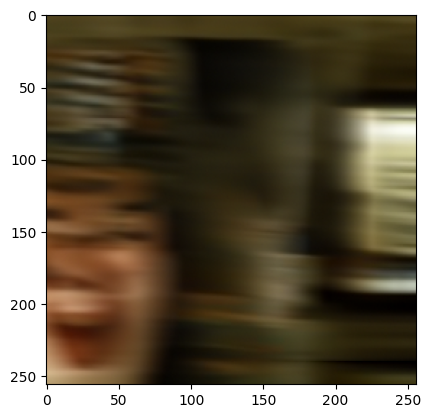

In [371]:
sample = ((ddpm_of_decoded_tensor[-1][0] + 1) * 127.5).clamp(0, 255).to(torch.uint8)
plt.imshow(ddpm_of_decoded_tensor[-1][0].permute(1,2,0).numpy())

In [382]:
reverse_encoding = spaced_diffusion.ddim_reverse_sample_loop_progressive(blur_model,ddpm_of_decoded_tensor[-1].cuda(2),
                                                                             clip_denoised=True)
ddpm_of_encoded_tensor = []
with torch.no_grad():
    for dic in tqdm(reverse_encoding):
        ddpm_of_encoded_tensor.append(dic['sample'].cpu())

100it [00:14,  6.97it/s]


In [379]:
inputs = ddpm_of_encoded_tensor[-1].cuda(2)
reverse_decoding = spaced_diffusion.ddim_sample_loop_progressive(blur_model,shape=[1,3,256,256],clip_denoised=True,
                                                                 noise=inputs)
ddpm_of_decoded_tensor = []
with torch.no_grad():
    for dic in tqdm(reverse_decoding):
        ddpm_of_decoded_tensor.append(dic['sample'].cpu())

100it [00:14,  6.99it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


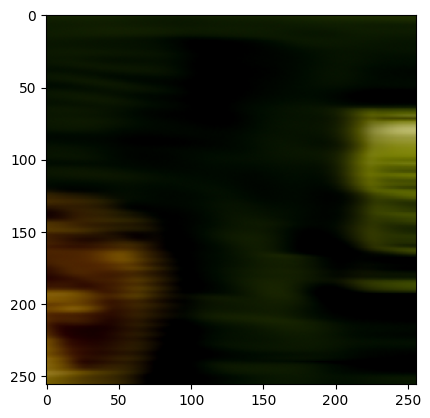

In [381]:
sample = ((ddpm_of_decoded_tensor[-1][0] + 1) * 127.5).clamp(0, 255).to(torch.uint8)
sample = ddpm_of_decoded_tensor[-1][0]
plt.imshow(sample.permute(1,2,0).numpy())

In [246]:
inputs = ddpm_of_decoded_tensor[-1][0].unsqueeze(0).cuda(3)
# inputs = ((inputs + 1) * 127.5).clamp(0, 255)/255
# inputs = ddpm_of_sampled_tensor[-1].cuda(1)
reverse_encoding = spaced_diffusion.ddim_reverse_sample_loop_progressive(imagenet_model,inputs ,
                                                                             clip_denoised=True)
ddpm_of_encoded_tensor = []
with torch.no_grad():
    for dic in tqdm(reverse_encoding):
        ddpm_of_encoded_tensor.append(dic['sample'].cpu())
inputs = ddpm_of_encoded_tensor[-1].cuda(3)
reverse_decoding = spaced_diffusion.ddim_sample_loop_progressive(imagenet_model,shape=[1,3,256,256],clip_denoised=True ,
                                                                 noise=inputs)
ddpm_of_decoded_tensor = []
with torch.no_grad():
    for dic in tqdm(reverse_decoding):
        ddpm_of_decoded_tensor.append(dic['sample'].cpu())

50it [00:07,  6.93it/s]


In [249]:
inputs = ddpm_of_encoded_tensor[-1].cuda(3)
reverse_decoding = spaced_diffusion.ddim_sample_loop_progressive(imagenet_model,shape=[1,3,256,256],clip_denoised=True ,
                                                                 noise=inputs)
ddpm_of_decoded_tensor = []
with torch.no_grad():
    for dic in tqdm(reverse_decoding):
        ddpm_of_decoded_tensor.append(dic['sample'].cpu())

50it [00:07,  6.93it/s]
